![alt text](DSN.png "DSN Hackathon")

The data is a structure dataset pull from the Kowope Mart’s database with few important features that can be used to predict defaulters in retail network. The data sample has been split into train and test with a volume of 56,000 and 24,000.

## DATA Description

Train.csv - this contains data on variables, risk scoring features, severity features, credit features, credit card features, time related features, precentage related features and other features as well as the default status.

test.csv - this contains data of all customers and loans for which the participants are to submit probability of default


#### Importing needed packages

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from time import time
import lightgbm as lgb
import xgboost as xgb
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
#!pip install catboost
import catboost
%matplotlib inline
from catboost import CatBoostClassifier
#!pip install scikit-optimize
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

import warnings
warnings.simplefilter('ignore')

In [ ]:
# importing and reading the dataset
train = pd.read_csv('/content/drive/My Drive/Train.csv')
test = pd.read_csv('/content/drive/My Drive/Test.csv')

In [ ]:
train.head()

,Applicant_ID,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50,default_status
0,Apcnt_1000000,3436.0,0.28505,1.6560,0.0,0.000,0.0,10689720.0,252072.0,4272776.0,11333126.0,4397256.0,2301324.0,7875694.0,96375139,112181765.0,1.0,1.0,1.0,3.0,3.0,134.655,NaN,NaN,134.655,4000.5,17064.0,11376.0,60.0,17064.0,5962.0,NaN,1052.0,8.0000,2.0,NaN,12.0,12.0,4.0,0.0,NaN,NaN,0.392854,2.02,0.711632,0.0,0.0,charge,NaN,1.129518,0.044335,no
1,Apcnt_1000004,3456.0,0.67400,0.2342,0.0,0.000,0.0,898979.0,497531.0,9073814.0,2533168.0,244292.0,3982971.0,2141445.0,28141427,45169902.0,1.0,1.0,1.0,2.0,2.0,109.230,11385.24,14584.29,86.685,4161.0,13413.0,8942.0,304.0,13413.0,5780.0,NaN,2554.0,17.5000,0.0,0.0,16.0,24.0,8.0,0.0,NaN,NaN,0.314281,8.08,0.183584,NaN,0.0,charge,349.805730,1.620483,0.322436,no
2,Apcnt_1000008,3276.0,0.53845,3.1510,0.0,6.282,NaN,956940.0,NaN,192944.0,1079864.0,NaN,NaN,0.0,16576457,22452691.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1597.5,4746.0,3164.0,60.0,15696.0,NaN,14508.0,70.0,0.6666,0.0,NaN,12.0,0.0,6.0,0.0,149.6805,NaN,0.162965,18.18,0.791136,0.0,0.0,charge,NaN,1.513370,0.011640,yes
3,Apcnt_1000012,3372.0,0.17005,0.5050,0.0,0.000,192166.0,3044703.0,385499.0,3986472.0,3621979.0,NaN,771776.0,1186839.0,48187375,136297820.0,0.0,0.0,0.0,1.0,1.0,120.120,8580.00,0.00,85.800,1701.0,4014.0,2676.0,60.0,11679.0,NaN,NaN,522.0,7.8334,1.0,1.0,4.0,8.0,4.0,1.0,NaN,NaN,0.488884,2.02,0.685168,NaN,0.0,charge,89.940100,0.664452,0.082729,no
4,Apcnt_1000016,3370.0,0.77270,1.1010,0.0,0.000,1556.0,214728.0,214728.0,1284089.0,361770.0,396391.0,818456.0,511535.0,28141427,15292757.0,0.0,0.0,0.0,3.0,3.0,104.535,8360.19,10326.45,115.335,1551.0,3285.0,2190.0,60.0,19437.0,12958.0,5202.0,272.0,1.0000,0.0,0.0,24.0,2.0,24.0,0.0,150.0135,NaN,0.275000,12.12,0.438168,0.0,0.0,charge,97.887502,1.427891,0.045630,no


#### Feature Engineering

In [ ]:
# Labelencoding the categorical variables on the train data
train["default_status"] = LabelEncoder().fit_transform(train["default_status"])
train["form_field47"] = LabelEncoder().fit_transform(train["form_field47"])

In [ ]:
test.head()

,Applicant_ID,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50
0,Apcnt_1000032,3236.0,0.34875,10.2006,0.0000,0.0,418564.0,418564.0,418564.0,540710.0,0.0,1649749.0,5446.0,0.0,48187375,114686147.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1086.0,6204.0,2676.0,60.0,14691.0,9794.0,NaN,238.0,1.8334,0.0,NaN,22.0,2.0,14.0,0.0,NaN,NaN,0.825000,1.01,0.800000,NaN,0.0,charge,NaN,0.000000,0.011221
1,Apcnt_1000048,3284.0,1.27360,2.9606,9.0198,0.0,0.0,9858816.0,49014.0,1510098.0,18308285.0,622789.0,1025793.0,1396510.0,34694910,87479487.0,1.0,1.0,1.0,2.0,2.0,142.560,NaN,NaN,570.585,3082.5,10221.0,6814.0,60.0,11955.0,3528.0,NaN,1216.0,19.5000,3.0,NaN,30.0,18.0,14.0,2.0,NaN,18.8415,0.507694,4.04,0.623248,1.0,0.0,lending,NaN,0.504974,0.043525
2,Apcnt_1000052,NaN,0.27505,0.0600,0.0000,0.0,NaN,NaN,NaN,NaN,0.0,118256.0,NaN,NaN,21973443,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,852.0,4836.0,NaN,NaN,NaN,7.8334,0.0,NaN,2.0,NaN,0.0,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,charge,NaN,0.000000,NaN
3,Apcnt_1000076,3232.0,0.28505,2.8032,0.0000,0.0,0.0,473802.0,473802.0,1724437.0,493641.0,1391064.0,1176725.0,1220293.0,16576457,NaN,2.0,2.0,2.0,3.0,3.0,109.005,13050.00,NaN,109.005,1414.5,4197.0,2798.0,60.0,14964.0,NaN,NaN,248.0,9.0000,1.0,1.0,36.0,0.0,26.0,0.0,NaN,NaN,0.916663,2.02,0.464224,NaN,NaN,charge,90.163742,0.788809,0.104029
4,Apcnt_1000080,3466.0,2.09545,0.8318,2.5182,0.0,19839.0,1150662.0,1150662.0,7860523.0,5752921.0,271133.0,613064.0,4779643.0,48187375,72049802.0,0.0,0.0,0.0,3.0,3.0,139.065,469.29,469.29,15.180,2724.0,9855.0,6570.0,182.0,11679.0,5900.0,NaN,2388.0,16.6666,1.0,0.0,24.0,28.0,20.0,0.0,NaN,NaN,0.234047,23.23,0.726688,0.0,0.0,lending,1303.587148,1.637733,0.163124


In [ ]:
# Labelencoding the categorical variables on the test data
test["form_field47"] = LabelEncoder().fit_transform(test["form_field47"])

In [ ]:
train = train.fillna(-999)
test = test.fillna(-999)

In [ ]:
train.columns

Index(['Applicant_ID', 'form_field1', 'form_field2', 'form_field3',
       'form_field4', 'form_field5', 'form_field6', 'form_field7',
       'form_field8', 'form_field9', 'form_field10', 'form_field11',
       'form_field12', 'form_field13', 'form_field14', 'form_field15',
       'form_field16', 'form_field17', 'form_field18', 'form_field19',
       'form_field20', 'form_field21', 'form_field22', 'form_field23',
       'form_field24', 'form_field25', 'form_field26', 'form_field27',
       'form_field28', 'form_field29', 'form_field30', 'form_field31',
       'form_field32', 'form_field33', 'form_field34', 'form_field35',
       'form_field36', 'form_field37', 'form_field38', 'form_field39',
       'form_field40', 'form_field41', 'form_field42', 'form_field43',
       'form_field44', 'form_field45', 'form_field46', 'form_field47',
       'form_field48', 'form_field49', 'form_field50', 'default_status'],
      dtype='object')

In [ ]:
# Combining the train and test
df=train.append(test,ignore_index=True)
df.tail()

,Applicant_ID,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50,default_status
79995,Apcnt_999940,3258.0,0.37925,0.5698,5.1282,0.0000,-999.0,2280318.0,-999.0,-999.0,2280318.0,1743887.0,-999.0,0.0,21973443,126128971.0,-999.0,-999.0,-999.0,0.0,0.0,-999.000,-999.000,-999.000,-999.000,547.5,-999.0,-999.0,304.0,3741.0,2068.0,-999.0,24.0,0.3334,0.0,0.0,6.0,0.0,6.0,0.0,-999.0,92.6910,1.100000,0.00,0.800000,-999.0,1.0,0,-999.000000,0.000000,-999.000000,NaN
79996,Apcnt_999956,3514.0,0.95260,0.0000,0.0000,0.0000,1494538.0,4773419.0,4773419.0,89718571.0,12999991.0,-999.0,48989882.0,97696961.0,96375139,-999.0,0.0,0.0,0.0,3.0,3.0,123.195,11663.055,-999.000,123.195,1485.0,6387.0,4258.0,60772.0,14691.0,3286.0,-999.0,586.0,14.1666,0.0,0.0,10.0,2.0,8.0,0.0,-999.0,125.0220,0.000000,12.12,0.196400,0.0,0.0,0,4200.072959,3.000000,0.930931,NaN
79997,Apcnt_999976,3302.0,0.05755,4.2394,0.0000,25.4376,-999.0,49403.0,-999.0,-999.0,49403.0,215895.0,-999.0,0.0,21973443,-999.0,-999.0,-999.0,0.0,0.0,1.0,-999.000,13080.000,-999.000,-999.000,2304.0,-999.0,-999.0,60.0,10038.0,-999.0,5109.0,202.0,5.3334,0.0,-999.0,8.0,4.0,2.0,0.0,-999.0,-999.0000,1.100000,1.01,0.800000,-999.0,0.0,0,-999.000000,4.855060,-999.000000,NaN
79998,Apcnt_999984,3334.0,0.75670,1.4428,0.0000,0.0000,0.0,2513329.0,37733.0,393668.0,2551062.0,121757.0,355935.0,673748.0,16576457,-999.0,1.0,2.0,2.0,2.0,2.0,129.435,13024.995,13024.995,138.450,706.5,2463.0,1642.0,0.0,6297.0,2312.0,-999.0,62.0,2.6666,0.0,0.0,12.0,0.0,4.0,0.0,-999.0,31.1955,0.440000,2.02,0.519776,-999.0,0.0,0,27.325129,0.818733,0.023749,NaN
79999,Apcnt_999992,3324.0,0.44840,2.3170,6.7176,0.0000,-999.0,5305182.0,-999.0,18885950.0,5361587.0,1121098.0,0.0,3031477.0,48187375,-999.0,0.0,0.0,0.0,0.0,1.0,-999.000,-999.000,-999.000,124.980,9319.5,30204.0,20136.0,60.0,30204.0,9672.0,-999.0,1634.0,24.8334,0.0,-999.0,6.0,8.0,0.0,0.0,-999.0,112.3035,0.314281,3.03,0.544352,0.0,1.0,0,-999.000000,0.000000,0.391927,NaN


In [ ]:
print(df.shape)

(80000, 52)


In [ ]:
df.drop(['Applicant_ID'],axis=1,inplace=True)


In [ ]:
dftrain=df[df['default_status'].isnull()!=True]
dftest=df[df['default_status'].isnull()==True]
dftrain.head()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50,default_status
0,3436.0,0.28505,1.6560,0.0,0.000,0.0,10689720.0,252072.0,4272776.0,11333126.0,4397256.0,2301324.0,7875694.0,96375139,112181765.0,1.0,1.0,1.0,3.0,3.0,134.655,-999.00,-999.00,134.655,4000.5,17064.0,11376.0,60.0,17064.0,5962.0,-999.0,1052.0,8.0000,2.0,-999.0,12.0,12.0,4.0,0.0,-999.0000,-999.0,0.392854,2.02,0.711632,0.0,0.0,0,-999.000000,1.129518,0.044335,0.0
1,3456.0,0.67400,0.2342,0.0,0.000,0.0,898979.0,497531.0,9073814.0,2533168.0,244292.0,3982971.0,2141445.0,28141427,45169902.0,1.0,1.0,1.0,2.0,2.0,109.230,11385.24,14584.29,86.685,4161.0,13413.0,8942.0,304.0,13413.0,5780.0,-999.0,2554.0,17.5000,0.0,0.0,16.0,24.0,8.0,0.0,-999.0000,-999.0,0.314281,8.08,0.183584,-999.0,0.0,0,349.805730,1.620483,0.322436,0.0
2,3276.0,0.53845,3.1510,0.0,6.282,-999.0,956940.0,-999.0,192944.0,1079864.0,-999.0,-999.0,0.0,16576457,22452691.0,-999.0,-999.0,-999.0,0.0,0.0,-999.000,-999.00,-999.00,-999.000,1597.5,4746.0,3164.0,60.0,15696.0,-999.0,14508.0,70.0,0.6666,0.0,-999.0,12.0,0.0,6.0,0.0,149.6805,-999.0,0.162965,18.18,0.791136,0.0,0.0,0,-999.000000,1.513370,0.011640,1.0
3,3372.0,0.17005,0.5050,0.0,0.000,192166.0,3044703.0,385499.0,3986472.0,3621979.0,-999.0,771776.0,1186839.0,48187375,136297820.0,0.0,0.0,0.0,1.0,1.0,120.120,8580.00,0.00,85.800,1701.0,4014.0,2676.0,60.0,11679.0,-999.0,-999.0,522.0,7.8334,1.0,1.0,4.0,8.0,4.0,1.0,-999.0000,-999.0,0.488884,2.02,0.685168,-999.0,0.0,0,89.940100,0.664452,0.082729,0.0
4,3370.0,0.77270,1.1010,0.0,0.000,1556.0,214728.0,214728.0,1284089.0,361770.0,396391.0,818456.0,511535.0,28141427,15292757.0,0.0,0.0,0.0,3.0,3.0,104.535,8360.19,10326.45,115.335,1551.0,3285.0,2190.0,60.0,19437.0,12958.0,5202.0,272.0,1.0000,0.0,0.0,24.0,2.0,24.0,0.0,150.0135,-999.0,0.275000,12.12,0.438168,0.0,0.0,0,97.887502,1.427891,0.045630,0.0


In [ ]:
X,y=dftrain.drop('default_status',axis=1),dftrain['default_status']

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.3,
                                               random_state = 1994)

In [ ]:
categorical_features_indices = np.where(X_train.dtypes =='object')[0]
categorical_features_indices

array([], dtype=int64)

##### Hyperparameter Tuning - Learning_rate, n_estimators, random_state and l2_leaf_reg

In [ ]:


class ModelOptimizer:
    best_score = None
    opt = None
    
    def __init__(self, model, X_train, y_train,
                 categorical_columns_indices=None, n_fold=3, seed=1994, 
                 early_stopping_rounds=30, is_stratified=True, is_shuffle=True):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.categorical_columns_indices = categorical_columns_indices
        self.n_fold = n_fold
        self.seed = seed
        self.early_stopping_rounds = early_stopping_rounds
        self.is_stratified = is_stratified
        self.is_shuffle = is_shuffle
        
        
    def update_model(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self.model, k, v)
            
    def evaluate_model(self):
        pass
    
    def optimize(self, param_space, max_evals=10, n_random_starts=2):
        start_time = time.time()
        
        @use_named_args(param_space)
        def _minimize(**params):
            self.model.set_params(**params)
            return self.evaluate_model()
        
        opt = gp_minimize(_minimize, param_space, n_calls=max_evals, 
                          n_random_starts=n_random_starts,
                          random_state=2405, n_jobs=-1)
        best_values = opt.x
        optimal_values = dict(zip([param.name for param in param_space],
                                  best_values))
        best_score = opt.fun
        self.best_score = best_score
        self.opt = opt
        
        print('optimal_parameters: {}\noptimal score: {}\noptimization time: {}'
        .format(optimal_values, best_score, time.time() - start_time))
        print('updating model with optimal values')
        self.update_model(**optimal_values)
        plot_convergence(opt)
        return optimal_values
    
class CatboostOptimizer(ModelOptimizer):
    def evaluate_model(self):
        validation_scores = catboost.cv(
        catboost.Pool(self.X_train, 
                      self.y_train, 
                      cat_features=self.categorical_columns_indices),
        self.model.get_params(), 
        nfold=self.n_fold,
        stratified=self.is_stratified,
        seed=self.seed,
        early_stopping_rounds=self.early_stopping_rounds,
        shuffle=self.is_shuffle,
        verbose=100,
        plot=False)
        self.scores = validation_scores
        test_scores = validation_scores.iloc[:, 2]
        best_metric = test_scores.max()
        return 1 - best_metric

0:	test: 0.7904828	best: 0.7904828 (0)
100:	test: 0.8377579	best: 0.8377641 (99)
146:	test: 0.8382335	best: 0.8383315 (138)	total: 24.3s	remaining: 0us
0:	test: 0.7847210	best: 0.7847210 (0)
Stopped by overfitting detector  (30 iterations wait)
0:	test: 0.7952907	best: 0.7952907 (0)
Stopped by overfitting detector  (30 iterations wait)
0:	test: 0.7817927	best: 0.7817927 (0)
100:	test: 0.8333631	best: 0.8333631 (100)
200:	test: 0.8362217	best: 0.8362217 (200)
300:	test: 0.8375970	best: 0.8375970 (300)
400:	test: 0.8385232	best: 0.8385254 (399)
500:	test: 0.8390582	best: 0.8390582 (500)
600:	test: 0.8393600	best: 0.8393621 (590)
700:	test: 0.8395579	best: 0.8395822 (693)
Stopped by overfitting detector  (30 iterations wait)
0:	test: 0.7893483	best: 0.7893483 (0)
Stopped by overfitting detector  (30 iterations wait)
0:	test: 0.7903947	best: 0.7903947 (0)
100:	test: 0.8347721	best: 0.8347721 (100)
190:	test: 0.8374643	best: 0.8374643 (190)	total: 30.7s	remaining: 0us
0:	test: 0.7907567	bes

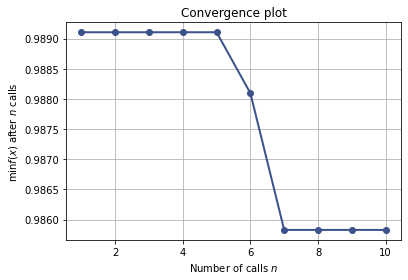

In [ ]:
cb = catboost.CatBoostClassifier( # use large n_estimators deliberately to make use of the early stopping
                         loss_function='Logloss',
                         eval_metric='AUC',
                         boosting_type='Ordered', # use permutations
                         
                         task_type="GPU",
                         use_best_model=True)


cb_optimizer = CatboostOptimizer(cb, X_train, y_train,
                  categorical_columns_indices=categorical_features_indices )


params_space = [Real(0.01, 0.8, name='learning_rate'), 
                Integer(100, 2000, name='n_estimators'), 
                Integer(10,2000, name='random_state'),
                Integer(3,8, name='l2_leaf_reg')]


cb_optimal_values = cb_optimizer.optimize(params_space)

### Evaluation 

In [ ]:

m=CatBoostClassifier(n_estimators=102,random_state=1997,
                     eval_metric='AUC',max_depth=6,
                     learning_rate= 0.03896091957635092,
                     l2_leaf_reg=8,  cat_features=categorical_features_indices,
                     use_best_model=True)


m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val, y_val)], 
      early_stopping_rounds=100,verbose=100)


p2=m.predict_proba(X_val)[:,-1]

0:	test: 0.7869031	test1: 0.7853204	best: 0.7853204 (0)	total: 38.6ms	remaining: 3.9s
100:	test: 0.8417039	test1: 0.8329614	best: 0.8329614 (100)	total: 3.13s	remaining: 31ms
101:	test: 0.8418402	test1: 0.8330488	best: 0.8330488 (101)	total: 3.16s	remaining: 0us

bestTest = 0.8330488024
bestIteration = 101



In [ ]:
df.columns

Index(['form_field1', 'form_field2', 'form_field3', 'form_field4',
       'form_field5', 'form_field6', 'form_field7', 'form_field8',
       'form_field9', 'form_field10', 'form_field11', 'form_field12',
       'form_field13', 'form_field14', 'form_field15', 'form_field16',
       'form_field17', 'form_field18', 'form_field19', 'form_field20',
       'form_field21', 'form_field22', 'form_field23', 'form_field24',
       'form_field25', 'form_field26', 'form_field27', 'form_field28',
       'form_field29', 'form_field30', 'form_field31', 'form_field32',
       'form_field33', 'form_field34', 'form_field35', 'form_field36',
       'form_field37', 'form_field38', 'form_field39', 'form_field40',
       'form_field41', 'form_field42', 'form_field43', 'form_field44',
       'form_field45', 'form_field46', 'form_field47', 'form_field48',
       'form_field49', 'form_field50', 'default_status'],
      dtype='object')

In [ ]:
# most important features
sorted(zip(m.feature_importances_,X_train),reverse=True)

[(20.359709528313083, 'form_field47'),
 (11.77283203543081, 'form_field1'),
 (10.788717233061186, 'form_field2'),
 (6.736268831432686, 'form_field6'),
 (4.331910263856169, 'form_field37'),
 (3.7963562099380583, 'form_field9'),
 (2.5427167681616973, 'form_field38'),
 (2.1649298343727343, 'form_field34'),
 (2.1168440687846832, 'form_field19'),
 (2.0831576466375963, 'form_field25'),
 (2.0060116831335724, 'form_field42'),
 (1.9760142405946435, 'form_field49'),
 (1.8936471135777178, 'form_field28'),
 (1.8911046980183832, 'form_field18'),
 (1.8897275865007146, 'form_field3'),
 (1.7231069945026192, 'form_field36'),
 (1.40652851378343, 'form_field40'),
 (1.4063888098489277, 'form_field7'),
 (1.3031422347330768, 'form_field21'),
 (1.2853242412866623, 'form_field13'),
 (1.2291156531603438, 'form_field32'),
 (1.092380415132007, 'form_field24'),
 (1.0561643075524405, 'form_field22'),
 (1.0448306394815514, 'form_field26'),
 (1.018193359879329, 'form_field15'),
 (1.0094640311152137, 'form_field4'),


In [ ]:

dftest.drop('default_status',axis=1,inplace=True)

#### 5 Folds Cross Validation 
###### coupled with stacking

In [ ]:

errcb=[]
y_pred_totcb=[]

fold=StratifiedKFold(n_splits=5,shuffle=True,random_state=1994)
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_val = X.iloc[train_index],X.iloc[test_index]
    y_train, y_val = y.iloc[train_index],y.iloc[test_index]
 
    cat1 = CatBoostClassifier(n_estimators=800, max_depth=8, random_state=14, 
                           learning_rate=0.033, task_type='GPU',
                            eval_metric='AUC', verbose = 500)

    xgb1 = XGBClassifier(n_estimators=800, max_depth=8, booster='gbtree', 
                         base_score=0.7,
                     learning_rate=0.033, reg_lambda=30,
                     subsample=0.9, colsample_bytree=0.9,
                     eval_metric='auc', random_state=20920)

    lgbm1 = LGBMClassifier(max_depth=8, num_leaves=64, boosting_type='gbdt',
                       learning_rate=0.01, reg_alpha=10, 
                       n_estimators=1500,subsample=0.9, 
                       colsample_bytree=0.9, random_state=2)


    model = StackingClassifier(estimators = [ ('model1', cat1),('model2', xgb1),
                                             ('model3', lgbm1)], 
                               final_estimator = LogisticRegression())
    
    model.fit(X_train,y_train)

    p = model.predict_proba(dftest)[:,-1]
    
    y_pred_totcb.append(p)

0:	learn: 0.8058980	total: 180ms	remaining: 2m 23s
500:	learn: 0.8646689	total: 59.6s	remaining: 35.6s
799:	learn: 0.8746789	total: 1m 37s	remaining: 0us
0:	learn: 0.8032732	total: 161ms	remaining: 2m 8s
500:	learn: 0.8693382	total: 1m 1s	remaining: 36.7s
799:	learn: 0.8824673	total: 1m 39s	remaining: 0us
0:	learn: 0.8017731	total: 86.1ms	remaining: 1m 8s
500:	learn: 0.8703444	total: 1m	remaining: 36.1s
799:	learn: 0.8842241	total: 1m 38s	remaining: 0us
0:	learn: 0.7959312	total: 81.6ms	remaining: 1m 5s
500:	learn: 0.8717675	total: 1m 1s	remaining: 36.7s
799:	learn: 0.8851137	total: 1m 39s	remaining: 0us
0:	learn: 0.8080600	total: 93.4ms	remaining: 1m 14s
500:	learn: 0.8719519	total: 1m 1s	remaining: 36.6s
799:	learn: 0.8839919	total: 1m 39s	remaining: 0us
0:	learn: 0.8061152	total: 93.6ms	remaining: 1m 14s
500:	learn: 0.8680886	total: 1m 2s	remaining: 37s
799:	learn: 0.8804983	total: 1m 40s	remaining: 0us
0:	learn: 0.8046136	total: 173ms	remaining: 2m 18s
500:	learn: 0.8650898	total: 

In [ ]:
s=pd.DataFrame({'Applicant_ID':test['Applicant_ID'],
                'default_status':np.mean(y_pred_totcb,0)})
s.head()


s.to_csv('cb20foldscatMostfeat22Opt_U13.csv',index=False)

#### Things Tried in Other Notebooks 
1. model tuning
2. Curbing Overfitting
3. tried many combinations of hyperparameters for XGB and LGBM models

###### Blending with Appropriate weights

In [6]:
import pandas as pd
blend2 = pd.read_csv('/content/blendedcube (1).csv')

blend4 = pd.read_csv('/content/blendedsquare.csv')
new_blend = blend2.copy()

new_blend['default_status']= (blend2['default_status']*0.70 + 
                              
                              blend4['default_status']*0.30)

new_blend.to_csv('blendedcube.csv', index=False)